# Analysis of Market Returns: Part 2

Here I will continue my analysis the distribution of market returns. From the previous noebook

In [1]:
# Importing the libraries I anticipate using
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import pandas_datareader.data as web
import statsmodels
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import datetime
import scipy.stats as stats
import quandl
import time

%matplotlib inline

## More Data

To make the remaining work easier, I am going to design a `Data` class to interact with get get and store the data that I will be using. I will also be introducing currency data from the European Central Bank data on Quandl.

In [2]:
# get my quandl api key, I don't want to show the key so I'll read it in.
f = open('/Users/kennypotts/Desktop/Data/quandl_api_key.txt', 'r')
key = f.read()
key = key.strip()
quandl.ApiConfig.api_key = key

In [3]:
data = quandl.get('ECB/EURUSD')
data.head()

,Value
Date,
1999-01-04,1.1789
1999-01-05,1.1790
1999-01-06,1.1743
1999-01-07,1.1632
1999-01-08,1.1659


Unfortunately, Quandle seems to only have a few free sources for currency prices which each offer only a few pairs. I am going to try to get this data from foreign exchange broker Oanda.

In [2]:
# Python wrapper for oanda API, this wrapper needs some work but will do the job for now I think.
import oandapy as opy

# get my oada api key, I don't want to show the key so I'll read it in.
f = open('/Users/kennypotts/Desktop/Data/oanda_api_key.txt', 'r')
key = f.read()
key = key.strip()

oanda = opy.API(environment='practice', access_token=key)

In [10]:
# I am going to try to get minutely data form oanda, 
# I have to do it in chuncks because they have a 5000 limit for each request

start = '2002-05-05'
end = '2016-07-01'

dates = pd.date_range(start=start, end=end, freq='D')
instrument = 'EUR_USD'
df = DataFrame()

print('fethcing data for ',instrument)
for i in range(0, len(dates) - 1):
    # Format of date required by oanda API
    d1 = str(dates[i]).replace(' ', 'T')
    d2 = str(dates[i + 1]).replace(' ', 'T')

    try:
        d = oanda.get_history(instrument = instrument, start=d1, end=d2,
                                 alignmentTimezone='America/New_York', granularity='M5')
        df = df.append(DataFrame(d['candles']))
    except:
        pass

df = df.set_index('time')
df.index = [pd.datetime.strptime(x,"%Y-%m-%dT%H:%M:%S.%fZ") for x in df.index]
eur_usd = df

fethcing data for  EUR_USD


In [11]:
print(len(eur_usd))
eur_usd.head()


767332


,closeAsk,closeBid,complete,highAsk,highBid,lowAsk,lowBid,openAsk,openBid,volume
2002-05-06 20:55:00,0.9184,0.9181,True,0.9184,0.9181,0.9184,0.9181,0.9184,0.9181,1
2002-05-07 20:55:00,0.9155,0.9152,True,0.9155,0.9152,0.9155,0.9152,0.9155,0.9152,1
2002-05-08 20:55:00,0.9045,0.9042,True,0.9045,0.9042,0.9045,0.9042,0.9045,0.9042,1
2002-05-09 20:55:00,0.9095,0.9092,True,0.9095,0.9092,0.9095,0.9092,0.9095,0.9092,1
2002-05-10 20:55:00,0.9145,0.9135,True,0.9145,0.9135,0.9145,0.9135,0.9145,0.9135,1


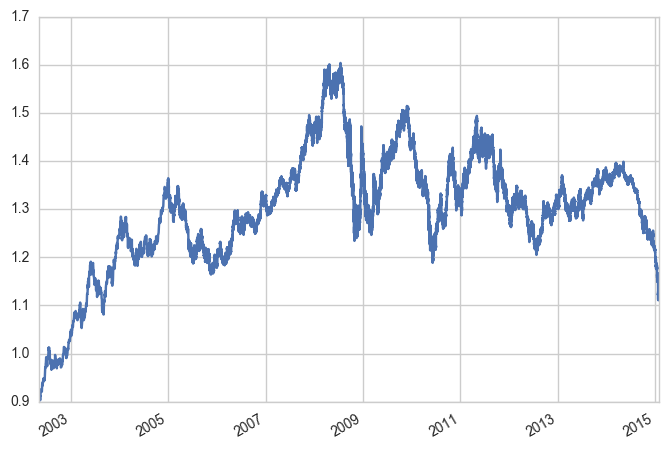

In [15]:
style.use('seaborn-notebook')

eur_usd.closeAsk.plot();

In [55]:
%%time
# I am going to try to get minutely data form oanda, 
# I have to do it in chuncks because they have a 5000 limit for each request

start = '2002-05-05'
end = '2016-07-01'

dates = pd.date_range(start=start, end=end, freq='6M')
instrument = 'EUR_USD'
df = DataFrame()

print('fethcing data for ',instrument)
for i in range(0, len(dates) - 1):
    # Format of date required by oanda API
    d1 = str(dates[i]).replace(' ', 'T')
    d2 = str(dates[i + 1]).replace(' ', 'T')

    try:
        d = oanda.get_history(instrument = instrument, start=d1, end=d2,
                                 alignmentTimezone='America/New_York', granularity='H1')
        df = df.append(DataFrame(d['candles']))
    except:
        pass

df = df.set_index('time')
df.index = [pd.datetime.strptime(x,"%Y-%m-%dT%H:%M:%S.%fZ") for x in df.index]
e_u = df

fethcing data for  EUR_USD
CPU times: user 2.51 s, sys: 128 ms, total: 2.63 s
Wall time: 10 s


In [52]:
start = '2002-05-05'
end = '2016-07-01'

dates = pd.date_range(start=start, end=end, freq='9M')

In [53]:
len(dates)

19

In [56]:
print(len(e_u))
e_u.tail()

74483


,closeAsk,closeBid,complete,highAsk,highBid,lowAsk,lowBid,openAsk,openBid,volume
2016-05-30 19:00:00,1.11414,1.11401,True,1.11431,1.11409,1.11371,1.11352,1.11384,1.11366,270
2016-05-30 20:00:00,1.11400,1.11358,True,1.11428,1.11408,1.11378,1.11352,1.11420,1.11402,309
2016-05-30 21:00:00,1.11365,1.11336,True,1.11407,1.11372,1.11363,1.11326,1.11401,1.11363,116
2016-05-30 22:00:00,1.11428,1.11409,True,1.11429,1.11410,1.11354,1.11335,1.11356,1.11338,359
2016-05-30 23:00:00,1.11484,1.11469,True,1.11504,1.11488,1.11428,1.11412,1.11429,1.11412,349


In [3]:
# Available instruments to trade

accts = oanda.get_accounts()
acct_id = accts['accounts'][0]['accountId']
ins = oanda.get_instruments(account_id=acct_id)['instruments']
ins_list = []
for i in ins:
    ins_list.append(i['instrument'])
    print(i['instrument'], end=', ')

AUD_CAD, AUD_CHF, AUD_HKD, AUD_JPY, AUD_NZD, AUD_SGD, AUD_USD, CAD_CHF, CAD_HKD, CAD_JPY, CAD_SGD, CHF_HKD, CHF_JPY, CHF_ZAR, EUR_AUD, EUR_CAD, EUR_CHF, EUR_CZK, EUR_DKK, EUR_GBP, EUR_HKD, EUR_HUF, EUR_JPY, EUR_NOK, EUR_NZD, EUR_PLN, EUR_SEK, EUR_SGD, EUR_TRY, EUR_USD, EUR_ZAR, GBP_AUD, GBP_CAD, GBP_CHF, GBP_HKD, GBP_JPY, GBP_NZD, GBP_PLN, GBP_SGD, GBP_USD, GBP_ZAR, HKD_JPY, NZD_CAD, NZD_CHF, NZD_HKD, NZD_JPY, NZD_SGD, NZD_USD, SGD_CHF, SGD_HKD, SGD_JPY, TRY_JPY, USD_CAD, USD_CHF, USD_CNH, USD_CZK, USD_DKK, USD_HKD, USD_HUF, USD_JPY, USD_MXN, USD_NOK, USD_PLN, USD_SAR, USD_SEK, USD_SGD, USD_THB, USD_TRY, USD_ZAR, ZAR_JPY, 

I am able to get all of the currency data that I nee from Oanda.

## Constructing the Data Object

The `Data` object, with which I will interact, holds onto the `Currencies` and and `Equities` classes. The `Currencies` class organizes currencies by their base currency and holds onto a number of `Currency_Base` objects, each of which holds a number of `Currency_Pair` objects. The `Currency_Pair` object finds and holds the data for a unique currency pair. The `Equities` object hold onto two categories of `Equity` objects, ETFs and regular equities. It also has a few functions which can be used to make selections of different `Equity` objects. Each `Equitiy` object finds and holds data on a unique equity.

In [3]:

class Equity:
    """
    Retrieves and holds data for a single equity
    """
    def __init__(self, symbol, start='1990-01-01', end='today'):
        self.symbol = symbol
        start = start.split('-')
        start = datetime.date(int(start[0]), int(start[1]), int(start[2]))
        
        if end == 'today':
            end = datetime.date.today()
        else:
            end = end.split('-')
            end = datetime.date(int(end[0]), int(end[1]), int(end[2]))
            
        # See if this data is already stored on the disk
        with pd.HDFStore('project_data.h5') as store:
            try:
                self.pricing = store["/equities/"+symbol+"/pricing"]
                if len(self.actions.index) > 0:
                    self.adj_pricing = store["/equities/"+symbol+"/adj_pricing"]
                self.returns = store["/equities/"+symbol+"/returns"].dropna(how='all')
                self.actions = strore['/equities/'+symbol+'/actions']
                self.start = self.pricing.index[0]
                self.end = self.pricing.index[-1]
            except:
                self.pricing = web.DataReader(self.symbol,'yahoo', start, end)
                store["/equities/"+symbol+"/pricing"] = self.pricing
                self.start = self.pricing.index[0]
                self.end = self.pricing.index[-1]
                self.actions = web.DataReader(self.symbol, 'yahoo-actions', self.start, self.end)
                store['/equities/'+symbol+'/actions'] = self.actions
                if len(self.actions.index) > 0:
                    self.add_adjusted_data()
                    store["/equities/"+symbol+"/adj_pricing"] = self.adj_pricing
                self.returns = np.log(1 + self.pricing['Adj Close'].pct_change())[1:]
                store["/equities/"+symbol+"/returns"] = self.returns
                
    def __repr__(self):
        return "Equity Object: "+self.symbol

        
        
    def add_adjusted_data(self):
        """
        Calculates and adds split adjusted price data as self.adj_pricing.

        Uses yahoo-actions data to determine when and how much stock plits were,
        if they have occured. The initial data are adjusted for the splits,
        with the exception of the Adj Close and Volume which have already been adjusted.
        Adds adjust data as self.adj_pricing
        """
        splits = self.actions[self.actions.action == 'SPLIT']
        self.adj_pricing = self.pricing.copy()
        if len(splits.index) > 0:
            # Find the index and date of the split
            split_idxs = {i:x for i,x in enumerate(self.adj_pricing.index.tolist()) if x in splits.index}
            columns = self.adj_pricing.columns.tolist()

            # adjust for the splits
            for idx, date in split_idxs.items():
                for col in range(len(columns)):
                    if columns[col] != 'Volume' and columns[col] != 'Adj Close':
                        # adjust the prices of the shares
                        self.adj_pricing.iloc[:idx, col] = self.adj_pricing.iloc[:idx, col]*splits.loc[date].value

class Equities:
    """
    Holds Equity Objects and data as attributes.
    """
    def __init__(self):
        with pd.HDFStore('project_data.h5') as store:
            self.equity_market_caps = store['market_cap_sr']
            try:
                self.removed_symbols = store['removed_symbols']
            except:
                self.removed_symbols = Series([])
                store['removed_symbols'] = self.removed_symbols
        self.equity_symbols = list(self.equity_market_caps.keys())
        self.ETFs = {'SPY': Equity('SPY'), 'IWM': Equity('IWM'), 'QQQ': Equity('QQQ'),
                     'DIA': Equity('DIA'), 'VTI': Equity('VTI')}
        
        self.equities = {}
        
    def __repr__(self):
        return ("Equities Object, Number of Equities: "+str(len(self.equity_symbols))
                +", Number of ETFs: "+str(len(self.ETFs.keys())))
        
    def get_equity(self, symbol):
        """
        Gets and the Equity object for a specific symbol.
        
        If the data for the Equity object does not exist, the Equity is created if possible.
        If the Equity data cannot be found, will return None, otherwise will return the Equity.
        """
        if symbol in self.equities.keys():
            return self.equities[symbol]
        elif symbol in self.ETFs.keys():
            return self.ETFs[symbol]
        elif symbol in self.equity_symbols:
            try:
                new_equity = Equity(symbol)
                self.equities[symbol] = new_equity
                return new_equity
            except Exception as e:
                #print('Could not retrieve data for this symbol '+symbol
                #      +", removing symbol and selecting a new one")
                # Remove bad symbol
                self.equity_symbols.remove(symbol)
                self.equity_market_caps = self.equity_market_caps[self.equity_market_caps.index != symbol]
                self.removed_symbols = self.removed_symbols.append(Series([symbol],
                                                                          index=[self.removed_symbols.shape[0]]))
                
                return None
        else:
            print('Data unavailable for ',symbol)
            return None
        
            
    def random_selection(self, size=1, include_ETFs=False):
        """
        Returns a random selection of equity objects of the specified size.
        
        Chosen without replacement. include_ETFs=False by default, set to True to inclue ETFs.
        Will return None if size < 1
        """
        size = int(size)
        if include_ETFs:
            symbols = list(np.random.choice(self.equity_symbols + list(self.ETFs.keys())
                                            , size=size, replace=False))
        else:
            symbols = list(np.random.choice(self.equity_symbols, size=size, replace=False))
        if size > 0:
            selections = []
            for i in range(size):
                eq = self.get_equity(symbols[i])
                while eq == None:
                    if include_ETFs:
                        new_symbol = list(np.random.choice(self.equity_symbols + list(self.ETFs.keys()),
                                                        size=1, replace=False))[0]
                    else:
                        new_symbol = list(np.random.choice(self.equity_symbols, size=1, replace=False))[0]
                    if new_symbol not in symbols:
                        symbols[i] = new_symbol
                        eq = self.get_equity(new_symbol)
                selections.append(eq)
            return selections
        return None
                    
        
        
    def __del__(self):
        """
        Stores the updated market_cap_sr Series
        """
        with pd.HDFStore('project_data.h5') as store:
            try:
                store['market_cap_sr'] = self.equity_market_caps
                store['removed_symbols'] = self.removed_symbols
            except:
                pass
        
        
class Currency_Pair:
    def __init__(self, base, quote, oanda):
        self.pair_name = quote+'/'+base
        # "no more than 120 requests per second on average, with bursts of no more than 60 requests"
        # add random delay to prevent request rejection
        time.sleep(np.random.randint(2,10))
        
        # Check disk for existing data, if nothing, then download
        with pd.HDFStore('project_data.h5') as store:
            try:
                self.pricing = store['/Currencies/Oanda/'+base+'/'+quote+'/pricing']
                self.returns = store['/Currencies/Oanda/'+base+'/'+quote+'/returns'].dropna(how='all')
            except:
                start = '2002-05-05' # first day oanda's currency data
                end = '2017-01-07'
                
                # I have to split it in chuncks because they have a 5000 limit for each request
                dates = pd.date_range(start=start, end=end, freq='6M')
                instrument = quote+'_'+base
                df = DataFrame()

                for i in range(0, len(dates) - 1):
                    # Format of date required by oanda API
                    d1 = str(dates[i]).replace(' ', 'T')
                    d2 = str(dates[i + 1]).replace(' ', 'T')

                    try:
                        d = oanda.get_history(instrument = instrument, start=d1, end=d2,
                                                 alignmentTimezone='America/New_York', granularity='H1')
                        df = df.append(DataFrame(d['candles']))
                    except:
                        pass
                if len(df) > 0:
                    df = df.set_index('time')
                    df.index = [pd.datetime.strptime(x,"%Y-%m-%dT%H:%M:%S.%fZ") for x in df.index]
                    self.pricing = df

                    self.returns = np.log(1 + self.pricing.closeAsk.pct_change())[1:]
                    store['/Currencies/Oanda/'+base+'/'+quote+'/pricing'] = self.pricing
                    store['/Currencies/Oanda/'+base+'/'+quote+'/returns'] = self.returns
                    print('Successfully downloaded ',quote,'/',base,' from oanda.')
        
        self.start = self.pricing.index[0]
        self.end = self.pricing.index[-1]
        
    def __repr__(self):
        return "Currency Pair: "+self.pair_name
               
            
class Currency_Base:
    def __init__(self, base, oanda_key):
        source = 'Oanda' # European Central Bank
        self.base = base
        self._list = []
        
        time.sleep(2)
        oanda = opy.API(environment='practice', access_token=oanda_key)
        
        # get a list of available instruments from oanda
        accts = oanda.get_accounts()
        acct_id = accts['accounts'][0]['accountId']
        ins = oanda.get_instruments(account_id=acct_id)['instruments']
        ins_list = []
        for i in ins:
            ins_list.append(i['instrument'])
        ins_list
        
        if base != 'EUR' and 'EUR_'+base in ins_list:
            try:
                self.EUR = Currency_Pair(self.base, 'EUR', oanda)
                self._list.append(self.EUR)
            except:
                pass
        if base != 'USD' and 'USD_'+base in ins_list:
            try:
                self.USD = Currency_Pair(self.base, 'USD', oanda)
                self._list.append(self.USD)
            except:
                pass
        if base != 'GBP' and 'GBP_'+base in ins_list:
            try:
                self.GBP = Currency_Pair(self.base, 'GBP', oanda)
                self._list.append(self.GBP)
            except:
                pass
        if base != 'CAD' and 'CAD_'+base in ins_list:
            try:
                self.CAD = Currency_Pair(self.base, 'CAD', oanda)
                self._list.append(self.CAD)
            except:
                pass
        if base != 'AUD' and 'AUD_'+base in ins_list:
            try:
                self.AUD = Currency_Pair(self.base, 'AUD', oanda)
                self._list.append(self.AUD)
            except:
                pass
        if base != 'JPY' and 'JPY_'+base in ins_list:
            try:
                self.JPY = Currency_Pair(self.base, 'JPY', oanda)
                self._list.append(self.JPY)
            except:
                pass
        if base != 'CHF' and 'CHF_'+base in ins_list:
            try:
                self.CHF = Currency_Pair(self.base, 'CHF', oanda)
                self._list.append(self.CHF)
            except:
                pass
        if base != 'NZD' and 'NZD_'+base in ins_list:
            try:
                self.NZD = Currency_Pair(self.base, 'NZD', oanda)
                self._list.append(self.NZD)
            except:
                pass
            
    def __repr__(self):
        return "Base Currency: "+self.base
    
    def __iter__(self):
        self.iter_n = 0
        return self

    def __next__(self):
        if self.iter_n < len(self._list):
            i = self.iter_n
            self.iter_n += 1
            return self._list[i]
        
        else:
            raise StopIteration
            
class Currencies:
    """
    Holds Currency_Base Objects.
    """
    def __init__(self, oanda_key):
        self.currency_list = ['EUR','USD','GBP','CAD','AUD','JPY','CHF','NZD']
        self.EUR = Currency_Base('EUR', oanda_key)
        self.USD = Currency_Base('USD', oanda_key)
        self.GBP = Currency_Base('GBP', oanda_key)
        self.CAD = Currency_Base('CAD', oanda_key)
        self.AUD = Currency_Base('AUD', oanda_key)
        self.JPY = Currency_Base('JPY', oanda_key)
        self.CHF = Currency_Base('CHF', oanda_key)
        self.NZD = Currency_Base('NZD', oanda_key)
        
    def __repr__(self):
        return "Currencies Object, Cross Rates for "+" ".join(self.currency_list)
    
    def __iter__(self):
        self.iter_n = 0
        return self

    def __next__(self):
        _list = [self.EUR, self.USD, self.GBP, self.CAD,
                 self.AUD, self.JPY, self.CHF, self.NZD]
        if self.iter_n < len(_list):
            i = self.iter_n
            self.iter_n += 1
            return _list[i]
        
        else:
            raise StopIteration
    
class Data:
    """
    Data object holds Currencies and Equities objects.
    """
    def __init__(self, oanda_key):
        self.currencies = Currencies(oanda_key)
        self.equities = Equities()
        
    def __repr__(self):
        return "Data Object, holds Equities and Currencies Objects."

Here I will initialize my new data object with which I will interact to get the data I will need. I there is other data that I will require, I will add it to the Data class.

In [4]:
# get my oada api key, I don't want to show the key so I'll read it in.
f = open('/Users/kennypotts/Desktop/Data/oanda_api_key.txt', 'r')
key = f.read()
key = key.strip()

In [5]:
%%time
data = Data(key)

CPU times: user 1.24 s, sys: 220 ms, total: 1.46 s
Wall time: 3min 3s


In [58]:
style.use('seaborn-notebook')

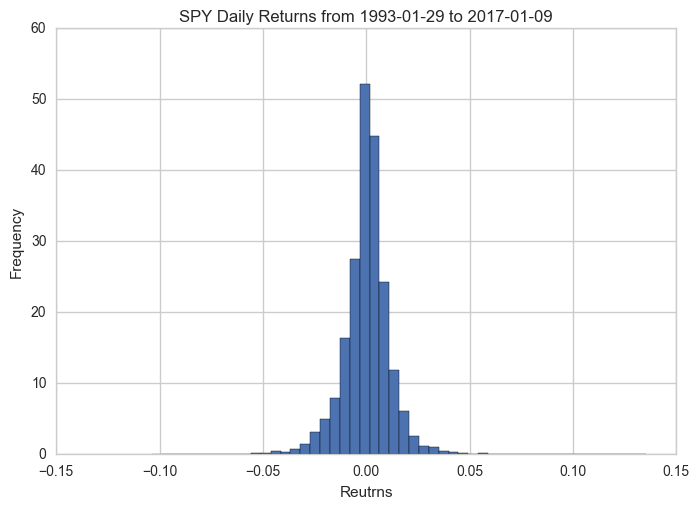

In [14]:
SPY = data.equities.ETFs['SPY']
SPY.returns.hist(bins=50, normed='true')
plt.xlabel('Reutrns')
plt.ylabel('Frequency')
plt.title('{0} Daily Returns from {1} to {2}'.format(SPY.symbol, SPY.start.date(), SPY.end.date()));

### Adjusting Time Frames

All of the equities data in the Data object have a daily frequency. The currency data, however, have an hourly frequency. Pandas DataFrames have a great built in function called `resample` that can return a sample of the data at a time frame larger than that of the underlying data. The pandas datetime object allows many different time frames including the following:

 - B - business day frequency
 - D - calendar day frequency
 - W - weekly frequency
 - M - month end frequency
 - SM - semi-month end frequency (15th and end of month)
 - A - year end frequency
 - H - hourly frequency
 - T - minutely frequency
 - S - secondly frequency

In [13]:
pd.DataFrame.resample?

In [37]:
eur_jpy = data.currencies.JPY.EUR
# B for business days
eur_jpy.pricing.resample('B').first().head()

,closeAsk,closeBid,complete,highAsk,highBid,lowAsk,lowBid,openAsk,openBid,volume
2002-05-31,116.06,115.96,1.0,116.06,115.96,116.06,115.96,116.06,115.96,1.0
2002-06-03,116.33,116.29,1.0,116.33,116.29,116.33,116.29,116.33,116.29,1.0
2002-06-04,116.64,116.60,1.0,116.64,116.60,116.64,116.60,116.64,116.60,1.0
2002-06-05,116.88,116.84,1.0,116.88,116.84,116.88,116.84,116.88,116.84,1.0
2002-06-06,117.62,117.58,1.0,117.62,117.58,117.62,117.58,117.62,117.58,1.0


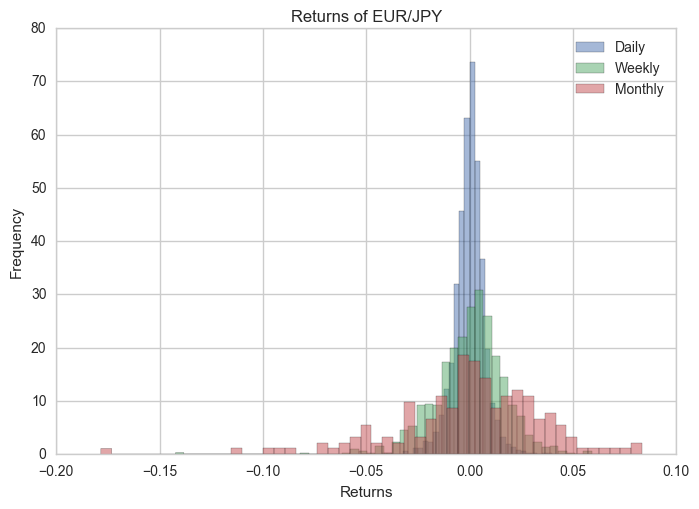

In [59]:
ej_daily_returns = np.log(1 + eur_jpy.pricing.resample('B').first().closeAsk.pct_change()).dropna()
ej_weekly_returns = np.log(1 + eur_jpy.pricing.resample('W').first().closeAsk.pct_change()).dropna()
ej_monthly_returns = np.log(1 + eur_jpy.pricing.resample('M').first().closeAsk.pct_change()).dropna()



plt.hist(ej_daily_returns, bins=50, alpha=0.5, normed=True, stacked=True, label='Daily')
plt.hist(ej_weekly_returns, bins=50, alpha=0.5, normed=True,stacked=True, label='Weekly')
plt.hist(ej_monthly_returns, bins=50, alpha=0.5, normed=True, stacked=True, label='Monthly')
plt.ylabel('Frequency')
plt.xlabel('Returns')
plt.title('Returns of '+eur_jpy.pair_name)
plt.legend();

In [62]:
DataFrame.resample?

In [66]:
eur_jpy.pricing.closeAsk.resample('B').ohlc().tail()

,open,high,low,close
2016-11-23,118.087,119.002,117.777,118.672
2016-11-24,118.555,119.710,118.555,119.632
2016-11-25,120.043,120.147,119.468,119.531
2016-11-28,119.408,119.476,118.597,118.597
2016-11-29,118.808,119.902,118.676,119.765


In [72]:
eur_jpy.pricing.closeAsk.resample('B').ohlc().head(25)

,open,high,low,close
2002-05-31,116.06,116.06,115.98,115.98
2002-06-03,116.33,116.33,116.33,116.33
2002-06-04,116.64,116.64,116.64,116.64
2002-06-05,116.88,116.88,116.88,116.88
2002-06-06,117.62,117.62,117.62,117.62
2002-06-07,117.46,117.46,117.39,117.39
2002-06-10,117.85,117.85,117.85,117.85
2002-06-11,118.84,118.84,118.84,118.84
2002-06-12,118.67,118.67,118.67,118.67
2002-06-13,117.85,117.85,117.85,117.85


In [18]:
print('Available Currency Pairs: ')
for currnecy in data.currencies:
    for pair in currnecy:
        print(pair.pair_name, end=', ')

Available Currency Pairs: 
EUR/USD, GBP/USD, AUD/USD, NZD/USD, EUR/GBP, EUR/CAD, USD/CAD, GBP/CAD, AUD/CAD, NZD/CAD, EUR/AUD, GBP/AUD, EUR/JPY, USD/JPY, GBP/JPY, CAD/JPY, AUD/JPY, CHF/JPY, NZD/JPY, EUR/CHF, USD/CHF, GBP/CHF, CAD/CHF, AUD/CHF, NZD/CHF, EUR/NZD, GBP/NZD, AUD/NZD, 

## Back to the Analysis

Now that I have easy access to a lot of data, I will resume the analysis of market returns. At the end of Part 1 I left of on the Jarque-Bera test with a couple examples. Now that I have a more efficient Data object to work with, I will many tests for many assets.

In [26]:
def jarque_bera_equities(data, n=60, cutoff=0.05, seed=False):
    """
    Performs Jarque-Bera test on the returns of n equities.
    
    Selects n random equities from data and performs JB test.
    Returns number of rejections, rejection percent, scores, p-values.
    """
    if seed:
        np.random.seed(seed)
    num_rejections = 0
    scores = np.zeros(n)
    p_values = np.ones(n)
    assets = data.equities.random_selection(size=n)
    for i in range(len(assets)):
        scores[i], p_values[i] = stats.jarque_bera(assets[i].returns)
        if p_values[i] <= cutoff:
            num_rejections += 1
    rejection_pct = 100 * float(num_rejections) / float(n)
    
    return num_rejections, rejection_pct, scores, p_values

In [27]:
num_rejections, rejection_pct, scores, p_values = jarque_bera_equities(data, n=50)

In [28]:
print('percentage of rejections: ',rejection_pct)

percentage of rejections:  98.0


In [30]:
num_rejections, rejection_pct, scores, p_values = jarque_bera_equities(data, n=150)
print('percentage of rejections: ',rejection_pct)

/Users/kennypotts/anaconda/envs/python3/lib/python3.5/site-packages/tables/path.py:100: NaturalNameWarning: object name is not a valid Python identifier: 'CIG.C'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)


percentage of rejections:  99.33333333333333


In [31]:
num_rejections

149

Out of the 150 tested equities, 149 of them failed the Jarque-Bera test. Let's take a look at currencies.

In [38]:
def jarque_bera_currencies(data, cutoff=0.05, seed=False):
    """
    Performs Jarque-Bera test on the returns of n equities.
    
    Selects n random equities from data and performs JB test.
    Returns number of rejections, rejection percent, scores, p-values.
    """
    if seed:
        np.random.seed(seed)
    num_rejections = 0
    scores = []
    p_values = []
    for base in data.currencies:
        for pair in base:
            results = stats.jarque_bera(pair.returns)
            scores.append(results[0])
            p_values.append(results[1])
            if results[1] <= cutoff:
                num_rejections += 1
    rejection_pct = 100 * float(num_rejections) / float(len(scores))
    
    return num_rejections, rejection_pct, scores, p_values

In [39]:
num_rejections, rejection_pct, scores, p_values = jarque_bera_currencies(data)
print('percentage of rejections: ',rejection_pct)
print('number of rejections: ',num_rejections)

percentage of rejections:  100.0
number of rejections:  49


## Jarque-Bera Conclusions

From the Jarque-Bera test results it seems clear that equity and currency market returns are not normally distributed. The next question is whether we can model them with something else, say another type of distribution, or maybe it isn't even safe to model returns in this way.

## A Visual Comparison

So far I have only used histograms and statistical test to show that markets are non-normal. Histograms, however, make it hard to view the discrepancies between a normal distribution and empirical data. For this, there is a better option

### Q-Q Plots

The Q-Q plot, or [quantile-quantile plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) plot the quantiles of two distributions against one another. In my case one of the distributions is observed data. If the two distributions are a close match, they will have a linear relationsip between quantiles and therefor show up as a straight line on the plot. From a Q-Q plot it is easy to see the differences in shape of the distributions. If the sample distribution is leptokurtic, then plotted against the normal distribution it will curve down going left and curve up going right, showing a greateer frequency of extreme events.

References:

 1. [Quantile-Quantile Plots, Jones](http://people.reed.edu/~jones/Courses/P14.pdf)
 2. [Kemp, Malcolm H. D. Extreme Events: Robust Portfolio Construction in the Presence of Fat Tails. Hoboken, NJ: Wiley, 2011. Print.](https://www.overdrive.com/media/661986/extreme-events)

I will first show what we would expect to see on the Q-Q plot if a sample was taken from a normally distributed random variable. I will create synthetic data.

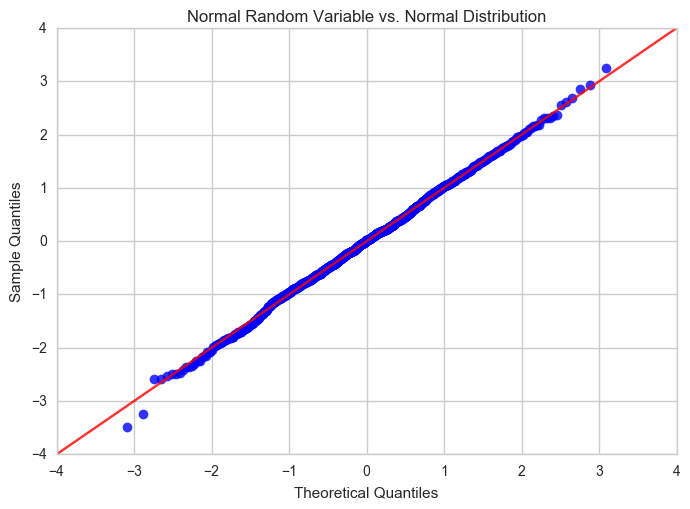

In [168]:
# synthetic normal data
x = np.random.normal(size=1000)

# plot Q-Q
fig, ax1 = plt.subplots()
sm.qqplot(x, fit=True, line='45', ax=ax1)
for l in ax1.lines:
    l.set_alpha(.8)
plt.title('Normal Random Variable vs. Normal Distribution');

Let's then compare this to the Q-Q plot for the SPY returns.

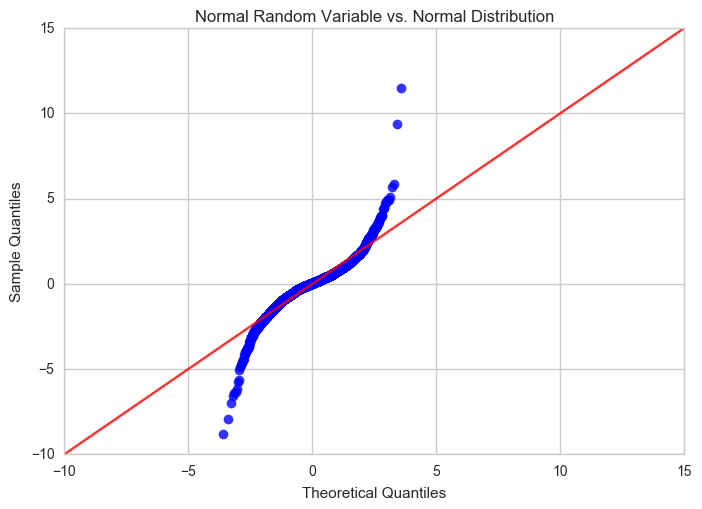

In [171]:
SPY = data.equities.ETFs['SPY']

# plot Q-Q
fig, ax1 = plt.subplots()
sm.qqplot(SPY.returns, fit=True, line='45', ax=ax1)
for l in ax1.lines:
    l.set_alpha(.8)
plt.title('Normal Random Variable vs. Normal Distribution');

This shape is indicative of a fat tail distribution relative to the normal distribution. The distribution for SPY returns shows 8$\sigma$ - 9$\sigma$ data points that corresond to 3$\sigma$ or 4$\sigma$ data points from a normal distribution.